### corrPlaylist_1.ipynb

In [182]:
import os 
import numpy as np
import pandas as pd 
from glob import glob # for grabbing files with wildcards
from itertools import combinations # for song 1/song 2 combinations

%autosave 300 

Autosaving every 300 seconds


In [24]:
# Define directories 
currPath = os.getcwd()
dataPath = os.path.abspath(os.path.join(currPath, os.pardir, 'data/playlist_subset'))

# Get the names of the playlists 
playlists = os.listdir(dataPath); playlists = [x for x in playlists if x.endswith('.gz')]; playlists.sort()

#### Get song frequency (across the entire playlist subset)

In [288]:
# Create our frequency master dataframe 
freq_master = []

# For every playlist file...
for p in playlists: 
    curr_playlist = pd.read_csv(os.path.join(dataPath, p), compression = 'gzip')
    curr_playlist = curr_playlist[['artist_name', 'track_name', 'track_uri', 'pid', 'name']]

    # Get the frequency for each song across playlists 
    curr_playlist_freq = curr_playlist.groupby(['artist_name', 'track_name', 'track_uri'])['pid'] \
                       .nunique() \
                       .reset_index(name='playlist_count_%i' % playlists.index(p))
    freq_master.append(curr_playlist_freq)
    

    print('Found song frequencies for:', p)


Found song frequencies for: playlist_subset_1.csv.gz
Found song frequencies for: playlist_subset_2.csv.gz
Found song frequencies for: playlist_subset_3.csv.gz
Found song frequencies for: playlist_subset_4.csv.gz


In [124]:
# Then, get the sum across columns 
freq_master = pd.concat(freq_master) # initialize df
freq_master.groupby('track_uri', as_index=False).sum(numeric_only=True) # group by track identifier 

# Organize frequencies according to each song in one row (instead of multiple rows per song)
merged_freq = (
    freq_master
    .fillna(0)
    .groupby('track_uri', as_index=False)[['playlist_count_0', 'playlist_count_1', 'playlist_count_2', 'playlist_count_3']]  # your specific columns
    .sum()
)

# Combine our song metadata with our frequencies
metadata = freq_master.groupby('track_uri', as_index=False).first()
metadata = metadata.drop(columns=['playlist_count_0', 'playlist_count_1', 'playlist_count_2', 'playlist_count_3', 'total_freq'])
merged_freq = pd.merge(merged_freq, metadata, on='track_uri')

# Then, get the summed frequency across playlist files
merged_freq['total'] = merged_freq[['playlist_count_0', 'playlist_count_1', 'playlist_count_2', 'playlist_count_3']].sum(axis=1)

# Sort our dataframe by the most frequent songs
merged_freq = merged_freq.sort_values(by='total', ascending = False) # organize frequencies by most to least
merged_freq.reset_index(drop=True, inplace=True)

# Save our merged frequency dataframe in our dataframe
merged_freq.to_csv(os.path.join(dataPath, 'freq/song_frequency.csv.gz'), index=False, compression = 'gzip')

#### Work with subset of data (300 songs)

In [197]:
# Get the subset of data (300 most frequency songs)
freq_subset = merged_freq[:300]

# Create the dummy correlation matrix to fill in later
corr_matrix = np.zeros((len(freq_subset), len(freq_subset)), dtype=int)

In [ ]:
# First, assign each song with an idx for our future dataframe (via making a dictionary)
track_idx = {song: idx for idx, song in enumerate(freq_subset['track_uri'].values)}

In [203]:
# For each playlist, check songs accordingly... 
for p in playlists: 
    playlist_df = pd.read_csv(os.path.join(dataPath, p), compression = 'gzip')
    playlist_df = playlist_df[['artist_name', 'track_name', 'track_uri', 'pid', 'name']]

    # For every playlist... (chosen by their playlist id)
    for pid in np.unique(playlist_df['pid'].values):
        curr_playlist = playlist_df[playlist_df['pid'] == pid]

        # See whether song from subset are present in current playlist 
        tracks_in_playlist = [x for x in curr_playlist['track_uri'] if x in track_idx] 

        # Then, apply numbers to co-present songs 
        for song1, song2 in combinations(set(tracks_in_playlist), 2):  # set() avoids duplicates within a playlist
            idx1 = track_idx[song1]; idx2 = track_idx[song2]
            corr_matrix[idx1, idx2] += 1; corr_matrix[idx2, idx1] += 1


In [216]:
# Get song names for each track
song_names = []
for x, y in track_idx.items(): 
    # For each track, get the song title 
    song_names.append(freq_subset[freq_subset['track_uri'] == x]['track_name'].values[0])

# Then, apply the song names to the index and columns of our correlation matrix 
corr_matrix_df = pd.DataFrame(corr_matrix, index=song_names, columns=song_names)

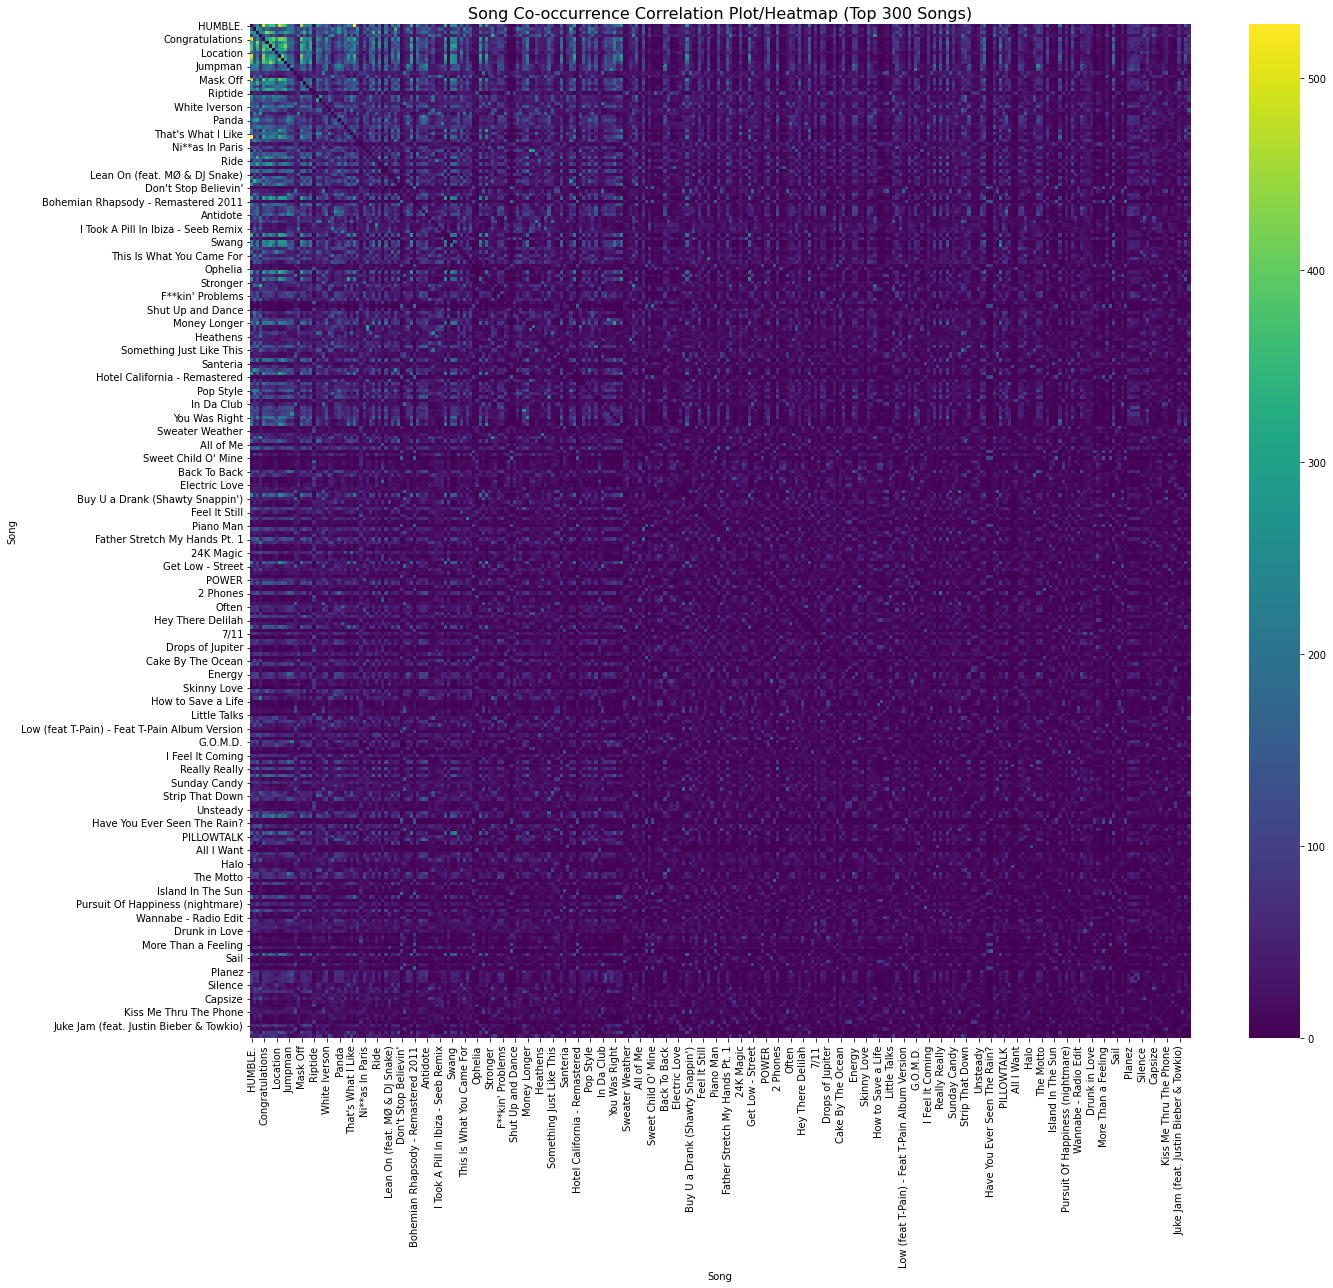

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 18))  # Adjust size as needed
sns.heatmap(corr_matrix_df, cmap="viridis")  # Other options: "Blues", "magma", "coolwarm"
plt.title("Song Co-occurrence Correlation Plot/Heatmap (Top 300 Songs)", fontsize=16)
plt.xlabel("Song")
plt.ylabel("Song")
plt.tight_layout()
plt.show()

#### Run a PCA

In [298]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) # determine how many dimensions
song_transformed = pca.fit_transform(corr_matrix_df.values) # fitting and transforming at the same time

In [299]:
# Also, get the names for the top 15 most frequent songs (so we can label later)
top15_songs = freq_subset[:15]['track_name'].values

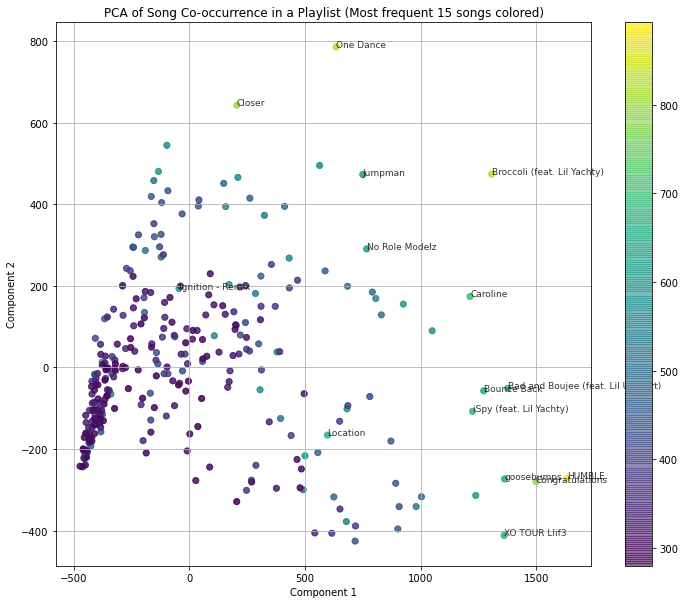

In [300]:
# Create the pca dataframe
pca_df = pd.DataFrame(song_transformed, columns=['PC1', 'PC2'], index=corr_matrix_df.index) # place pca transformed vals in dataframe

# Also, include the playlist frequencies in our dataset (for coloring later)
pca_df['playlist_freq'] = freq_subset['total'].values

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['playlist_freq'], alpha=0.6, cmap='viridis')
plt.colorbar(plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['playlist_freq'], alpha=0.6, cmap='viridis')) # include colorbar

# Find the location of the top 15 songs + label them
for song in top15_songs:
    x = pca_df.loc[song, 'PC1']
    y = pca_df.loc[song, 'PC2']
    plt.text(x, y, song, fontsize=9, alpha=0.8)

plt.title("PCA of Song Co-occurrence in a Playlist (Most frequent 15 songs colored)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()
